In [2]:
try:
    %load_ext watermark
    %watermark -a 'Sudeep Dalai' -v -p torch
except ImportError:
    !pip install watermark
    %load_ext watermark
    %watermark -a 'Sudeep Dalai' -v -p torch

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Author: Sudeep Dalai

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 7.34.0

torch: 2.5.1+cu121



# LeNet-5 MNIST Digits Classifier

This notebook implements the classic **LeNet-5** convolutional network [1] and applies it to **MNIST digit classification**. The basic architecture of LeNet-5 is shown below:

---

### LeNet-5 Architecture Overview

LeNet-5 is commonly regarded as the pioneer of convolutional neural networks, consisting of a very simple architecture (by modern standards). In total, LeNet-5 consists of only **7 layers**:

- **3 convolutional layers**: C1, C3, C5.
- **2 average pooling layers** (subsampling layers): S2 & S4.
- **1 fully connected layer**: F6.
- **1 output layer**.

---
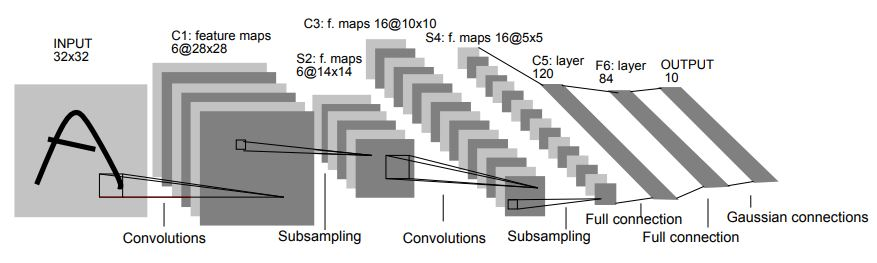

### Key Details

- **Convolutional layers** use **5x5 kernels** with a stride of **1**.
- The **two average pooling (subsampling) layers** are **2x2** pixels wide with a stride of **1**.
- Throughout the network, **tanh sigmoid activation functions** are used. (In this notebook, we replace these with **ReLU activations**.)
- The **output layer** uses **10 custom Euclidean Radial Basis Function (RBF) neurons**. (In this notebook, we replace these with **softmax activations**.)
- The **input size** is **32x32 pixels**. For the MNIST dataset, we rescale the images from **28x28** to **32x32** to match this input dimension. Alternatively, we would have to modify the architecture to achieve an error rate below 1% on the MNIST dataset, which was very close to the state-of-the-art at the time (produced by a boosted ensemble of three **LeNet-4** networks).

---

### References

- **[1]** Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based learning applied to document recognition." *Proceedings of the IEEE*, November 1998.


## Imports

In [30]:
# Import PyTorch
import torch
from torch import nn
from torch.utils.data import DataLoader

# Import Torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms

# Import matplotlib
import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu121
0.20.1+cu121


## Settings

In [31]:
# Hyperparameters
RANDOM_SEED = 42
LEARNING_RATE = 0.01
BATCH_SIZE = 128
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 32 * 32
NUM_CLASSES = 10

# Other
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## MNIST Dataset

In [32]:
resize_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

train_data = datasets.MNIST(root='data',
                            train=True,
                            download=False,
                            transform=resize_transform)

test_data = datasets.MNIST(root='data',
                            train=False,
                            download=False,
                            transform=resize_transform)

## Data Exploration

In [33]:
len(train_data), len(test_data)

(60000, 10000)

In [34]:
image, label = train_data[0]

In [6]:
class_names = train_data.classes
class_to_idx = train_data.class_to_idx
class_names, class_to_idx

(['0 - zero',
  '1 - one',
  '2 - two',
  '3 - three',
  '4 - four',
  '5 - five',
  '6 - six',
  '7 - seven',
  '8 - eight',
  '9 - nine'],
 {'0 - zero': 0,
  '1 - one': 1,
  '2 - two': 2,
  '3 - three': 3,
  '4 - four': 4,
  '5 - five': 5,
  '6 - six': 6,
  '7 - seven': 7,
  '8 - eight': 8,
  '9 - nine': 9})

In [7]:
print(f'Image Shape: {image.shape}, Label: {class_names[label]}')

Image Shape: torch.Size([1, 32, 32]), Label: 5 - five


## Data Visualization

'5 - five'

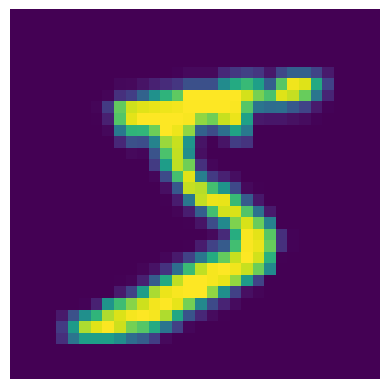

In [8]:
plt.imshow(image.squeeze())
plt.axis(False)

class_names[label]

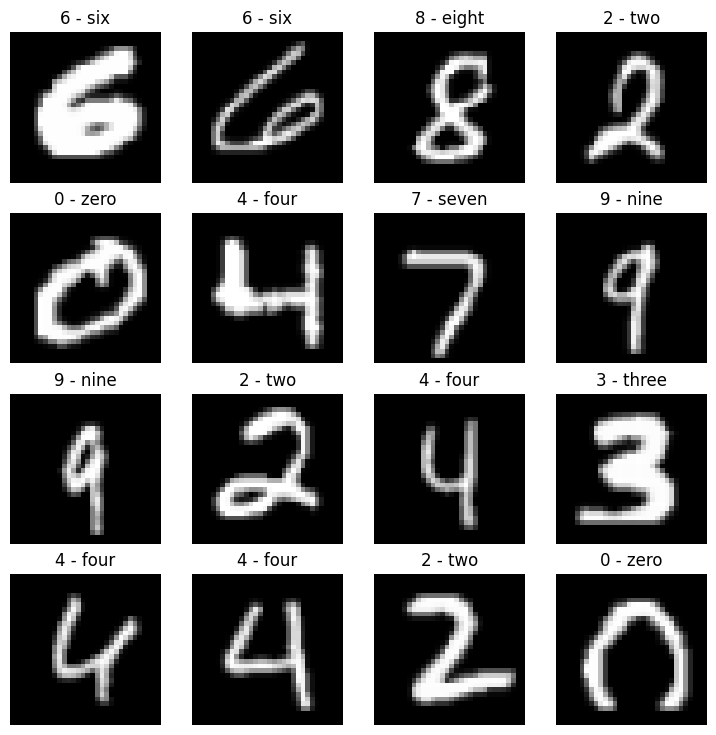

In [9]:
# Plot multiple Images
torch.manual_seed(RANDOM_SEED)

fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), (1,)).item()
    image, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.title(class_names[label])
    plt.imshow(image.squeeze(), cmap='gray')
    plt.axis(False)

## DataLoaders

In [10]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)
print(f'Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}')
print(f'Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}')

Length of train_dataloader: 469 batches of 128
Length of test_dataloader: 79 batches of 128


Image Size: torch.Size([1, 32, 32]) Label: 0


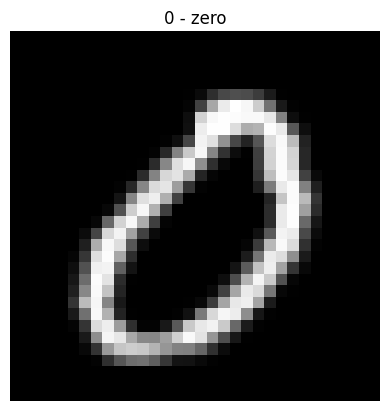

In [11]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))

random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis(False)

print(f'Image Size: {img.shape} Label: {label}')

## Model

In [12]:
class LeNet5(nn.Module):
    def __init__(self,
                 num_classes,
                 gray_scale=True):
        super().__init__()
        self.num_classes = num_classes
        self.in_channels = 1 if gray_scale else 3

        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=self.in_channels,
                      kernel_size=5,
                      out_channels=6),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=6,
                      kernel_size=5,
                      out_channels=16),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.conv_layer_3 = nn.Sequential(
            nn.Conv2d(in_channels=16,
                      kernel_size=5,
                      out_channels=120)
        )

        self.fc_layer_1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=120,
                      out_features=84),
            nn.Tanh()
        )

        self.fc_layer_2 = nn.Sequential(
            nn.Linear(in_features=84,
                      out_features=self.num_classes),
        )

    def forward(self, x):
        # print(f'Initial Shape: {x.shape}')
        x = self.conv_layer_1(x)
        # print(f'After passing through Conv 1: {x.shape}')
        x = self.conv_layer_2(x)
        # print(f'After passing through Conv 2: {x.shape}')
        x = self.conv_layer_3(x)
        # print(f'After passing through Conv 3: {x.shape}')
        x = self.fc_layer_1(x)
        # print(f'After passing through FC 1: {x.shape}')
        x = self.fc_layer_2(x)
        # print(f'After passing through FC 2: {x.shape}')
        return x

lenet_model = LeNet5(NUM_CLASSES, True)

## Loss Function and Optimizer

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=lenet_model.parameters(),
                            lr=LEARNING_RATE)

In [14]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## Training Model

In [15]:
def train_model(model, data_loader, loss_fn, accuracy_fn):
    cumulative_train_loss, cumulative_train_acc = 0, 0
    model.to(DEVICE)

    model.train()
    for batch_no, (X_train, y_train) in enumerate(train_dataloader):
        X_train, y_train = X_train.to(DEVICE), y_train.to(DEVICE)

        y_logits = model(X_train)

        batch_loss = loss_fn(y_logits, y_train)
        cumulative_train_loss += batch_loss
        cumulative_train_acc += accuracy_fn(y_true=y_train,
                                            y_pred=torch.argmax(torch.softmax(y_logits, dim=1), dim=1))

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

    loss_per_epoch = cumulative_train_loss / len(train_dataloader)
    acc_per_epoch = cumulative_train_acc / len(train_dataloader)
    print(f'Avg. Train Loss: {loss_per_epoch:.5f} | Avg. Train Acc: {acc_per_epoch:.2f}%')
    return loss_per_epoch, acc_per_epoch

In [16]:
def test_model(model, data_loader, loss_fn, accuracy_fn):
    cumulative_test_loss, cumulative_test_acc = 0, 0
    model.to(DEVICE)

    test_losses, test_accuracies = [], []

    model.eval()
    with torch.inference_mode():
        for X_test, y_test in data_loader:
            X_test, y_test = X_test.to(DEVICE), y_test.to(DEVICE)
            y_logits = model(X_test)

            batch_loss = loss_fn(y_logits, y_test)
            cumulative_test_loss += batch_loss
            cumulative_test_acc += accuracy_fn(y_true=y_test,
                                            y_pred=torch.argmax(torch.softmax(y_logits, dim=1), dim=1))

        loss_per_epoch = cumulative_test_loss / len(data_loader)
        acc_per_epoch = cumulative_test_acc / len(data_loader)
        print(f'Avg. Test Loss: {loss_per_epoch:.5f} | Avg. Test Acc: {acc_per_epoch:.2f}%')
        return loss_per_epoch, acc_per_epoch

In [29]:
train_losses_per_epoch, test_losses_per_epoch = [], []
train_acc_per_epoch, test_acc_per_epoch = [], []

for epoch in range(NUM_EPOCHS):
    print(f'Epoch {epoch}\n--------')
    train_loss, train_acc = train_model(lenet_model,
                                        train_dataloader,
                                        loss_fn,
                                        accuracy_fn)
    test_loss, test_acc = test_model(lenet_model,
                                        test_dataloader,
                                        loss_fn,
                                        accuracy_fn)

    train_losses_per_epoch.append(train_loss.cpu().item())
    test_losses_per_epoch.append(test_loss.cpu().item())

    train_acc_per_epoch.append(train_acc)
    test_acc_per_epoch.append(test_acc)

Epoch 0
--------
Avg. Train Loss: 0.11676 | Avg. Train Acc: 96.63%
Avg. Test Loss: 0.10534 | Avg. Test Acc: 96.96%
Epoch 1
--------
Avg. Train Loss: 0.10879 | Avg. Train Acc: 96.84%
Avg. Test Loss: 0.10004 | Avg. Test Acc: 96.79%
Epoch 2
--------
Avg. Train Loss: 0.10207 | Avg. Train Acc: 97.03%
Avg. Test Loss: 0.09072 | Avg. Test Acc: 97.37%
Epoch 3
--------
Avg. Train Loss: 0.09587 | Avg. Train Acc: 97.24%
Avg. Test Loss: 0.09279 | Avg. Test Acc: 97.37%
Epoch 4
--------
Avg. Train Loss: 0.09059 | Avg. Train Acc: 97.36%
Avg. Test Loss: 0.08438 | Avg. Test Acc: 97.37%
Epoch 5
--------
Avg. Train Loss: 0.08605 | Avg. Train Acc: 97.50%
Avg. Test Loss: 0.07949 | Avg. Test Acc: 97.71%
Epoch 6
--------
Avg. Train Loss: 0.08155 | Avg. Train Acc: 97.65%
Avg. Test Loss: 0.07567 | Avg. Test Acc: 97.70%
Epoch 7
--------
Avg. Train Loss: 0.07831 | Avg. Train Acc: 97.76%
Avg. Test Loss: 0.09974 | Avg. Test Acc: 96.86%
Epoch 8
--------
Avg. Train Loss: 0.07537 | Avg. Train Acc: 97.87%
Avg. Test Los

## Plot Graphs

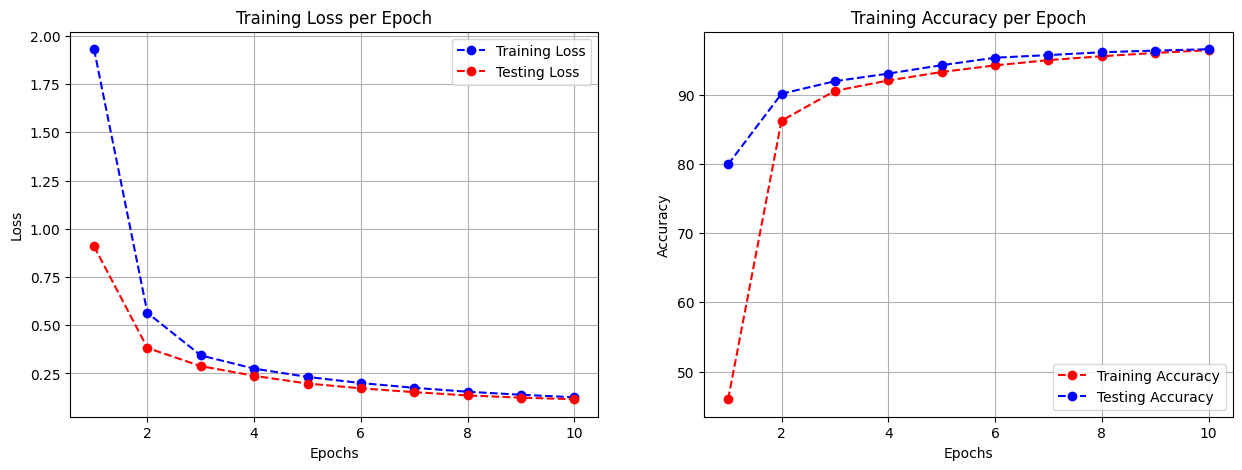

In [27]:
fig = plt.figure(figsize=(15, 5))

fig.add_subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS+1), train_losses_per_epoch, 'b--o', label='Training Loss')
plt.plot(range(1, NUM_EPOCHS+1), test_losses_per_epoch, 'r--o', label='Testing Loss')

# Add labels, title, grid, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.grid(True)
plt.legend()

fig.add_subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS+1), train_acc_per_epoch, 'r--o', label='Training Accuracy')
plt.plot(range(1, NUM_EPOCHS+1), test_acc_per_epoch, 'b--o', label='Testing Accuracy')

# Add labels, title, grid, and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy per Epoch')
plt.grid(True)
plt.legend()